# Node/Edge Removal Analysis Notebook

This notebook mirrors the shell helpers under `analysis/`:

1. Read every `EBE_*.dat` file
2. Compute the same column-wise statistics as `statistical_analysis`
3. Extract finite-size-scaling (FSS) curves
4. Fit the power law `y = A N^\alpha` and plot

Adjust `DATA_DIR` below if your files live elsewhere.

In [44]:
from __future__ import annotations

import math
import re
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import analysis_utils as au

plt.style.use('seaborn-v0_8-colorblind')


## Paths and constants

In [45]:
ROOT_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
CONFIGS = {
    'node': {
        'folder': 'node_percolation',
        'file_prefix': 'NR_EBE_',
        'ci_radius': 2,
    },
    'link': {
        'folder': 'link_percolation',
        'file_prefix': 'LR_EBE_',
        'ci_radius': 0,
    },
}

DATASET = 'node'  # choose 'node' or 'link'
cfg = CONFIGS[DATASET]
DATA_DIR = ROOT_DIR / cfg['folder']
FILE_PREFIX = cfg['file_prefix']
CI_RADIUS_FILTER = cfg['ci_radius']
pat = f"{FILE_PREFIX}*.dat"
stats_name = f"stats_{FILE_PREFIX}*.dat"
OUTPUT_DIR = DATA_DIR
DATA_DIR.mkdir(parents=True, exist_ok=True)


## Column metadata

In [46]:
COLUMN_MAP = au.COLUMN_MAP
COLUMN_LOOKUP = au.COLUMN_LOOKUP


## IO helpers

## FSS extraction + power law fit

In [47]:
au.compute_effective_exponents.__doc__


'Sliding-window effective exponents via weighted log-log fits.'

## Example workflow

In [48]:
summary = au.process_all_ebe(DATA_DIR, OUTPUT_DIR, pattern=pat, ci_radius_filter=CI_RADIUS_FILTER)
summary[['file', 'ci_radius', 'M_graphs', 'runs', 'N']]


,file,ci_radius,M_graphs,runs,N
0,NR_EBE_NR_ER_N1024_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,1024
1,NR_EBE_NR_ER_N2048_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,2048
2,NR_EBE_NR_ER_N256_c4.00_ci_L2_Mg1000_Mr1.dat,2,1000,1000,256
3,NR_EBE_NR_ER_N4096_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,4096
4,NR_EBE_NR_ER_N512_c4.00_ci_L2_Mg1000_Mr1.dat,2,1000,1000,512
5,NR_EBE_NR_ER_N8192_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,8192


In [49]:
stats_files = [
    path
    for path in sorted(OUTPUT_DIR.glob(stats_name))
    if (CI_RADIUS_FILTER is None or au.extract_ci_radius(path.name) == CI_RADIUS_FILTER)
]
stats_files[:3], len(stats_files)


([PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N1024_c4.00_ci_L2_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N2048_c4.00_ci_L2_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N256_c4.00_ci_L2_Mg1000_Mr1.dat')],
 6)

In [50]:
OBSERVABLES = [
    ("P(p+)", 4),
    ("P(q0)", 14),
]

fss_results = {}
fit_results = {}
for label, row in OBSERVABLES:
    fss = au.extract_fss(stats_files, row=row, value_kind='mean')
    fss_results[label] = fss
    fit_results[label] = au.weighted_log_fit(fss) if not fss.empty else None


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:228: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:229: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


In [51]:
EFFECTIVE_WINDOW = 3  # points per window for effective exponents


In [52]:
fss_results['P(p+)'], fit_results['P(p+)']


(      N      value     error  \
 0   256   121.0660  0.951774   
 1   512   217.1010  1.814425   
 2  1024   379.9140  1.083439   
 3  2048   656.8807  1.999009   
 4  4096  1129.7777  3.556965   
 5  8192  1902.9887  6.360699   
 
                                               source  
 0  stats_NR_EBE_NR_ER_N256_c4.00_ci_L2_Mg1000_Mr1...  
 1  stats_NR_EBE_NR_ER_N512_c4.00_ci_L2_Mg1000_Mr1...  
 2  stats_NR_EBE_NR_ER_N1024_c4.00_ci_L2_Mg10000_M...  
 3  stats_NR_EBE_NR_ER_N2048_c4.00_ci_L2_Mg10000_M...  
 4  stats_NR_EBE_NR_ER_N4096_c4.00_ci_L2_Mg10000_M...  
 5  stats_NR_EBE_NR_ER_N8192_c4.00_ci_L2_Mg10000_M...  ,
 {'A': 1.638924026320844,
  'A_err': 0.02100748878527967,
  'alpha': np.float64(0.7848991065338803),
  'alpha_err': 0.0016433770277186283,
  'chi2_red': 20.230739703276846,
  'fit_used_abs': False,
  'fit_value_sign': 1.0})

In [53]:
fss_results['P(q0)'], fit_results['P(q0)']


(      N      value     error  \
 0   256    71.4970  0.862728   
 1   512   130.1280  1.643875   
 2  1024   228.8741  0.961217   
 3  2048   399.6923  1.749557   
 4  4096   685.3325  3.118272   
 5  8192  1147.4431  5.534085   
 
                                               source  
 0  stats_NR_EBE_NR_ER_N256_c4.00_ci_L2_Mg1000_Mr1...  
 1  stats_NR_EBE_NR_ER_N512_c4.00_ci_L2_Mg1000_Mr1...  
 2  stats_NR_EBE_NR_ER_N1024_c4.00_ci_L2_Mg10000_M...  
 3  stats_NR_EBE_NR_ER_N2048_c4.00_ci_L2_Mg10000_M...  
 4  stats_NR_EBE_NR_ER_N4096_c4.00_ci_L2_Mg10000_M...  
 5  stats_NR_EBE_NR_ER_N8192_c4.00_ci_L2_Mg10000_M...  ,
 {'A': 0.9726573280941538,
  'A_err': 0.01842910382067793,
  'alpha': np.float64(0.7872892939149299),
  'alpha_err': 0.002422822102625647,
  'chi2_red': 17.591132753733508,
  'fit_used_abs': False,
  'fit_value_sign': 1.0})

## Giant component vs removed fraction

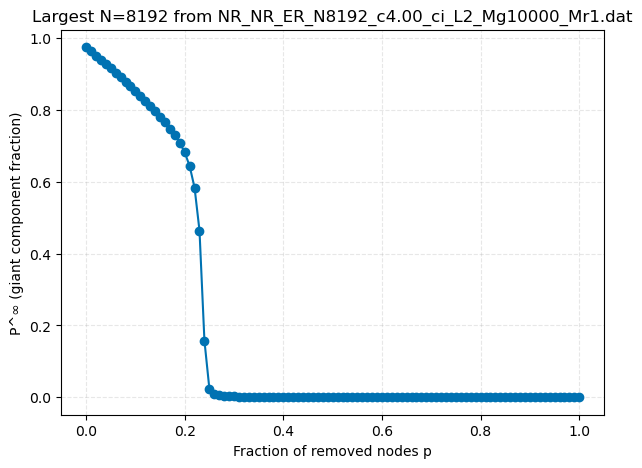

In [54]:
au.plot_giant_component_vs_p(DATA_DIR, FILE_PREFIX, CI_RADIUS_FILTER)


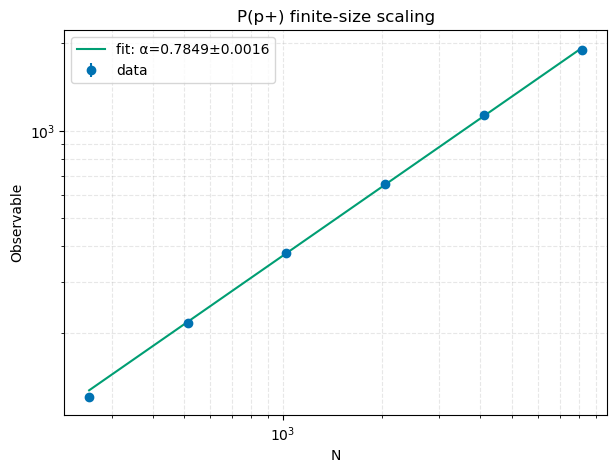

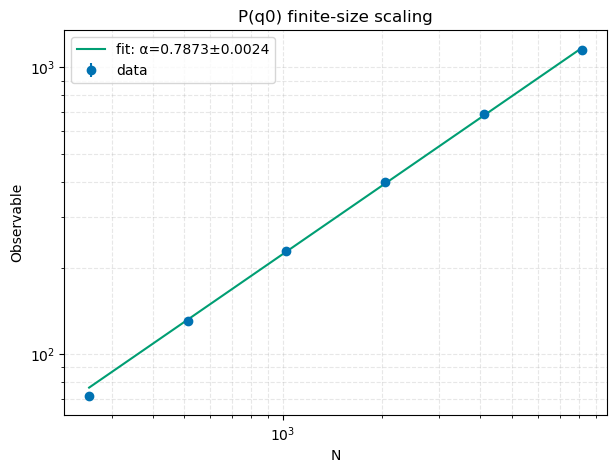

In [55]:
for label, _ in OBSERVABLES:
    fss = fss_results[label]
    fit = fit_results[label]
    if fss.empty or fit is None:
        print(f'No data for {label}')
        continue
    au.plot_fss_with_fit(fss, fit, title=f"{label} finite-size scaling")


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:228: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:229: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


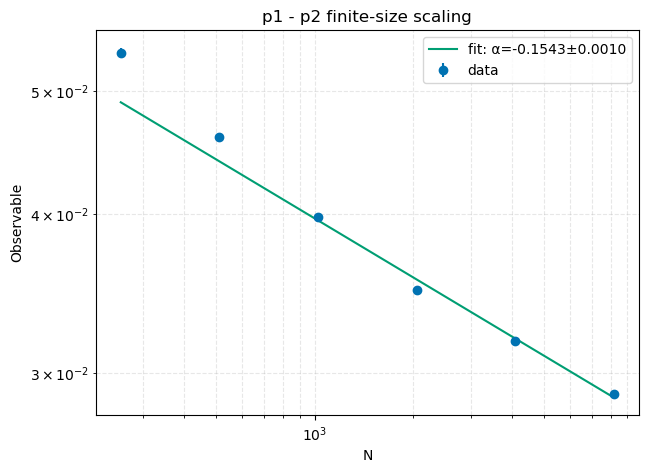

In [56]:
fss_gap = au.extract_p1_minus_p2(stats_files, value_kind='mean')
fit_gap = au.weighted_log_fit(fss_gap)
au.plot_fss_with_fit(fss_gap, fit_gap, title='p1 - p2 finite-size scaling')


In [57]:
effective_results = {}
for label, _ in OBSERVABLES:
    fss = fss_results[label]
    if fss.empty:
        effective_results[label] = pd.DataFrame()
    else:
        effective_results[label] = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)


In [58]:
effective_results['P(p+)']


,N_left,N_right,N_geom,exponent,exponent_err
0,256.0,1024.0,512.0,0.822230,0.005666
1,512.0,2048.0,1024.0,0.793925,0.004905
2,1024.0,4096.0,2048.0,0.786270,0.003059
3,2048.0,8192.0,4096.0,0.767761,0.003256


In [59]:
effective_results['P(q0)']


,N_left,N_right,N_geom,exponent,exponent_err
0,256.0,1024.0,512.0,0.835360,0.008620
1,512.0,2048.0,1024.0,0.806582,0.007201
2,1024.0,4096.0,2048.0,0.791477,0.004462
3,2048.0,8192.0,4096.0,0.761293,0.004691


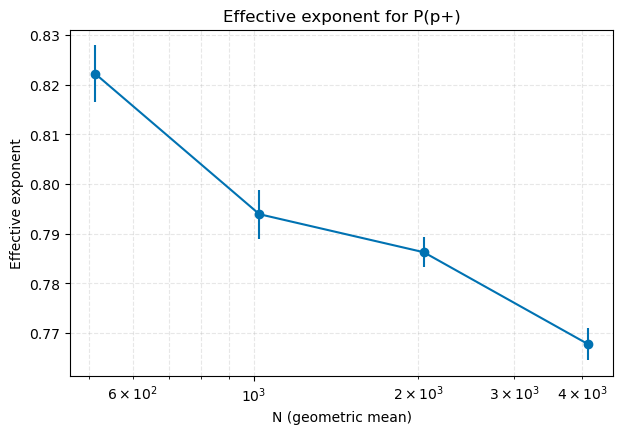

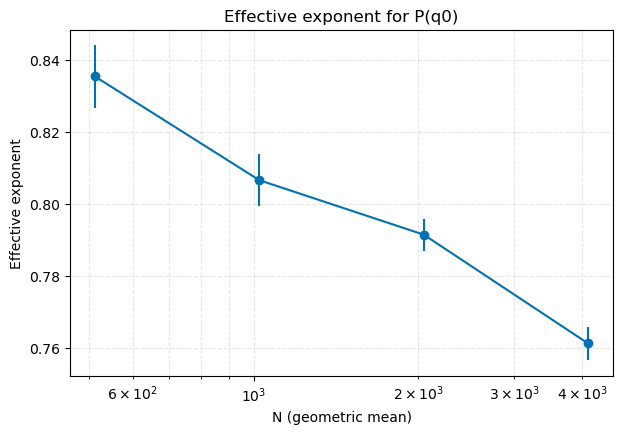

In [60]:
for label, _ in OBSERVABLES:
    eff = effective_results[label]
    if eff.empty:
        print(f'No effective exponents for {label}')
        continue
    au.plot_effective_exponent(eff, title=f"Effective exponent for {label}")


## Jump-height scaling

Plot the normalized jump height dP(p+) versus system size and fit a power law in log-log space.

      N     value     error
0   256  0.180105  0.001727
1   512  0.152887  0.001579
2  1024  0.128018  0.000432
3  2048  0.106155  0.000379
4  4096  0.088106  0.000324
5  8192  0.071843  0.000270
Jump-height fit: {'A': 0.8385713663611276, 'A_err': 0.012635876357234042, 'alpha': np.float64(-0.2716361275026014), 'alpha_err': 0.0019228735112199313, 'chi2_red': 5.830569454879124, 'fit_used_abs': False, 'fit_value_sign': 1.0}


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:228: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:229: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


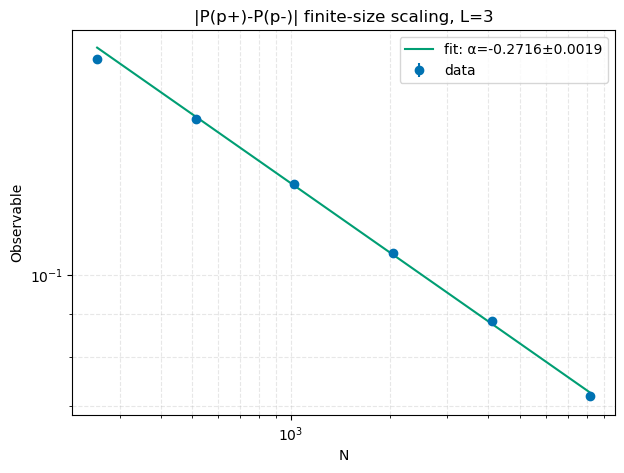

In [61]:
jump_fss = au.extract_fss(stats_files, row=3, value_kind='mean')
if jump_fss.empty:
    print('No jump-height data found; regenerate stats with updated binaries.')
else:
    jump_fit = au.weighted_log_fit(jump_fss)
    print(jump_fss[['N', 'value', 'error']])
    print('Jump-height fit:', jump_fit)
    au.plot_fss_with_fit(jump_fss, jump_fit, title='|P(p+)-P(p-)| finite-size scaling, L=3')
